## An application of optimization methods to least-squares regression models

\begin{align*}
  \text{minimize}\quad & ||y-X\beta||_2^2
\end{align*}

### Based on electricity market data from esios https://www.esios.ree.es/es

Data contents of the .csv files:
- price: hourly spot price
- coal: hourly total production coal plants
- gas: hourly total production combined cycle plants
- wind: hourly total production wind plants
- hidro: hourly total production hidro plants
- nuclear: hourly total production nuclear plants
- solar: hourly total production solar plants
- cogen: hourly total production cogeneration plants
- demand: hourly total demand in the market

We want to explain the spot price as a function of the other variables.

In [1]:
# Import all the required libraries, as well as the data in the .csv files

## Libraries

%matplotlib inline
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Read .csv files

price = pd.read_csv('price.csv',delimiter=';',usecols=['value'])
coal = pd.read_csv('coal.csv',delimiter=';',usecols=['value'])
gas = pd.read_csv('gas.csv',delimiter=';',usecols=['value'])
wind = pd.read_csv('wind.csv',delimiter=';',usecols=['value'])
hydro = pd.read_csv('hidro.csv',delimiter=';',usecols=['value'])
nuclear = pd.read_csv('nuclear.csv',delimiter=';',usecols=['value'])
solar = pd.read_csv('solar.csv',delimiter=';',usecols=['value'])
cogen = pd.read_csv('cogen.csv',delimiter=';',usecols=['value'])
demand = pd.read_csv('demand.csv',delimiter=';',usecols=['value'])

## Create data frame from all the preceding information

df = pd.concat([price, coal, gas, wind, hydro, nuclear, solar, cogen, demand],axis=1)
df.columns = ['price', 'coal', 'gas', 'wind', 'hydro', 'nuclear', 'solar', 'cogen', 'demand']

## Generate a standardized version of the data frame

normalized_df = (df - df.mean())/df.std()
#normalized_df = df

## An illustration for these data from different plots

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.plot(df['nuclear'],df['price'],'bo'),plt.xlabel('Nuclear'),plt.ylabel('Price')

plt.subplot(2, 2, 2)
plt.plot(df['coal'],df['price'],'bo'),plt.xlabel('Coal'),plt.ylabel('Price')

plt.subplot(2, 2, 3)
plt.plot(df['hydro'],df['price'],'bo'),plt.xlabel('Hydro'),plt.ylabel('Price')

plt.subplot(2, 2, 4)
plt.plot(df['wind'],df['price'],'bo'),plt.xlabel('Wind'),plt.ylabel('Price')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace = 0.4, hspace = 0.4)

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'price.csv'

In [2]:
# Prepare the data as matrices X and Y for the linear regression model

## Define the size of the testing set

ntest = 100

## Split the data into training and testing sets

[a,b] = df.shape

df_train = normalized_df.iloc[:(a-ntest), :]
df_test = normalized_df.iloc[(a-ntest):, :]

## Extract the data for the training data set (X,Y)

Y = np.array(df_train['price'])
Y = np.expand_dims(Y, axis=1)

X0 = np.ones([a-ntest,1])
X1 = np.array(df_train[df_train.columns[df_train.columns!='price']])
X = np.concatenate([X0, X1],axis=1)

## And the data for the testing data set (X_test,Y_test)

Y_test = np.array(df_test['price'])
Y_test = np.expand_dims(Y_test, axis=1)

X0_test = np.ones([ntest,1])
X1_test= np.array(df_test[df_test.columns[df_test.columns!='price']])
X_test = np.concatenate([X0_test, X1_test],axis=1)


## Solution with Sklearn

Values of the (exact) least squares coefficients - Sklearn:
beta intercept  -0.012
beta coal        0.363
beta gas         0.219
beta wind       -0.069
beta hydro       0.369
beta nuclear    -0.146
beta solar      -0.006
beta cogen       0.078
beta demand     -0.044

R^2 coefficient =   0.790


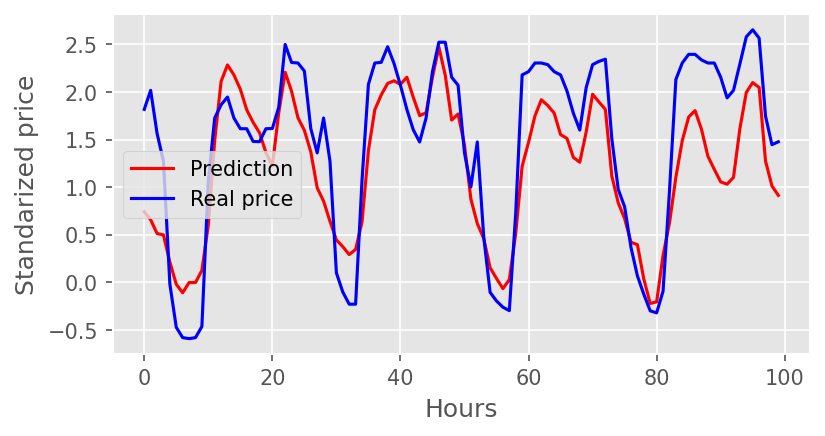

MAPE =   67.779 %


In [3]:
# Find the coefficients using Sklearn

## Get libraries

from sklearn import linear_model
import matplotlib.pyplot as plt

## Find coefficients

regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(X,Y)

## Print results

print('Values of the (exact) least squares coefficients - Sklearn:')
print('beta %-9s %7.3f' %('intercept',regr.coef_[0,0]))
for i in np.arange(1,b):
    print('beta %-9s %7.3f' %(df.columns[i],regr.coef_[0,i]))

print('\nR^2 coefficient = %7.3f' %regr.score(X, Y))

## Compare predicted and observed values

Y_pred = regr.predict(X_test)

plt.figure(figsize=(6,3),dpi=150)
plt.plot(Y_pred,'r',label='Prediction')
plt.plot(Y_test,'b',label='Real price')
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Standarized price')
plt.show()

## Print the mean absolute prediction error

MAPE = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100
print('MAPE = %8.3f %%' %MAPE)


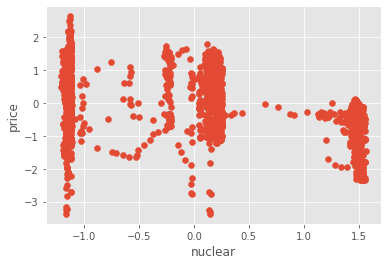

In [4]:
# Another plot of a particularly unusual subset (nuclear generation)

plt.scatter(X[:,5], Y),plt.xlabel('nuclear'),plt.ylabel('price')

plt.show()


We now compare different solution methods:

$\rightarrow$ Exact solution: $\beta_{ls}=(X^T X)^{-1}X^T y$

In [5]:
# Solve the system of linear equations (the normal equations)

time_start = time.process_time()

beta_ls_exact=np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),np.transpose(X)),Y)

time_elapsed = (time.process_time() - time_start)

## Print the results

print('Values of the (exact) least squares coefficients - Normal equations:')
print('beta %-9s %7.3f' %('intercept',beta_ls_exact[0]))
for i in np.arange(1,b):
    print('beta %-9s %7.3f' %(df.columns[i],beta_ls_exact[i]))

print('\nElapsed time = %9.5f' %(time_elapsed))


Values of the (exact) least squares coefficients - Normal equations:
beta intercept  -0.012
beta coal        0.363
beta gas         0.219
beta wind       -0.069
beta hydro       0.369
beta nuclear    -0.146
beta solar      -0.006
beta cogen       0.078
beta demand     -0.044

Elapsed time =   0.04688


$\rightarrow$ Definition of the objective function, gradient and Hessian

In [6]:
# Definition of the OF

def least_sq_reg(beta_ls, X, Y):
    beta_ls = np.matrix(beta_ls)
    z = Y - X*(beta_ls.T)
    return np.dot(z.T,z)

# Definition of the gradient

def least_sq_reg_der(beta_ls,X,Y):
    beta_ls = np.matrix(beta_ls)
    pp = -2*np.dot((Y - np.dot(X,(beta_ls).T)).T,X)
    aa = np.squeeze(np.asarray(pp))
    return aa

# Definition of the hessian matrix

def least_sq_reg_hess(beta_ls,X,Y):
    ss = 2*np.dot(np.transpose(X),X)
    return ss


## Gradient method

 $\rightarrow$ From an initial iterate $x_0$

$\rightarrow$ Compute search (descent) directions $p_k=-\nabla f(x_k)$

$\rightarrow$ Far from the solution, compute a steplength $\alpha_k>0$

$\rightarrow$ Movement:
$$x_{k+1} = x_k + \alpha_k\ p_k$$
Until convergence to a local solution

In [11]:
# Implementation of the gradient method

(a,b) = X.shape

## Parameters for the algorithm
sigma = 0.1
alpha = 1e-4
delta = 0.1
n_iter = 2000 # Maximum number of iterations
epsilon = 1e-5
tol = 10000

## Initial values for the variables and data containers

beta_lsg = np.zeros(b) # initial value for beta

OF_iter = np.zeros(n_iter)
tol_iter = np.zeros(n_iter)
alpha_iter = np.zeros(n_iter)

# Implement the gradient method

time_start = time.process_time()

i = 0

while (i <= n_iter-2) and (tol > epsilon):
    i = i + 1
    grad = least_sq_reg_der(beta_lsg,X,Y) # Gradient vector
    ddirect = -grad # Descent direction
##### Armijo rule to adjust alpha ######
    alpha=0.1
    while (least_sq_reg(beta_lsg+alpha*ddirect,X,Y) > least_sq_reg(beta_lsg,X,Y)+alpha*sigma*np.dot(ddirect,grad)):
        alpha = alpha*delta
#########################################
    beta_lsg = beta_lsg + alpha*ddirect
    
    OF_iter[i] = least_sq_reg(beta_lsg, X, Y)
    tol = np.linalg.norm(grad,ord=2)
    tol_iter[i] = tol
    alpha_iter[i] = alpha
    
time_elapsed = (time.process_time() - time_start)

## Print the results

print('Elapsed time = %8.5f' %(time_elapsed))
print('\nNumber of iterations = %5.0f' %i)
print('Objective function   = %11.5f' %OF_iter[i])
print('Optimality tolerance = %11.5f' %tol)

print('\nValues of the least squares coefficients - gradient method:')
print('beta %-9s %7.3f' %('intercept',beta_lsg[0]))
for ii in np.arange(1,b):
    print('beta %-9s %7.3f' %(df.columns[ii],beta_lsg[ii]))

beta_err = np.linalg.norm(np.transpose(beta_ls_exact)-beta_lsg,ord=2)/np.linalg.norm(beta_lsg,ord=2)
print('\nBeta coefficient error = %10.5f' %beta_err)


Elapsed time =  0.42188

Number of iterations =   285
Objective function   =   392.31993
Optimality tolerance =     0.00001

Values of the least squares coefficients - gradient method:
beta intercept  -0.012
beta coal        0.363
beta gas         0.219
beta wind       -0.069
beta hydro       0.369
beta nuclear    -0.146
beta solar      -0.006
beta cogen       0.078
beta demand     -0.044

Beta coefficient error =    0.00000


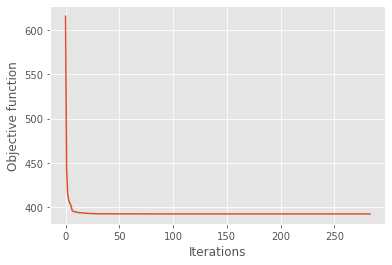

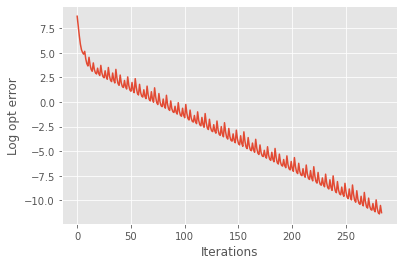

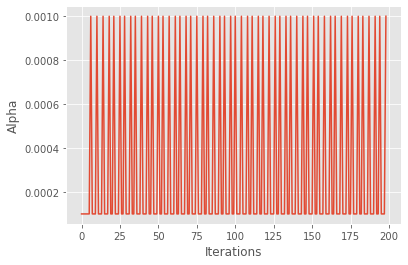

In [12]:
# Plot results showing the evolution of the algorithm

plt.plot(OF_iter[1:i]),plt.ylabel('Objective function'),plt.xlabel('Iterations')
plt.show()

plt.plot(np.log(tol_iter[1:i])),plt.ylabel('Log opt error'),plt.xlabel('Iterations')
plt.show()

plt.plot(alpha_iter[1:200]),plt.ylabel('Alpha'),plt.xlabel('Iterations')
plt.show()


## Newton's method

 $\rightarrow$ From an initial iterate $x_0$

$\rightarrow$ Compute a search (descent) direction $p_k=-(\nabla^2 f(x_k))^{-1} \nabla f(x_k)$, whenever $\nabla^2 f(x_k)$ is nonsingular. 

$\rightarrow$ Far from the solution, compute a steplength $\alpha_k>0$

$\rightarrow$ Movement:
$$x_{k+1} = x_k + \alpha_k\ p_k$$
Until convergence to a local solution.


In [18]:
# Implementation of Newton's method

(a,b) = X.shape

## Parameters for the algorithm

alpha = 1e-4
n_iter = 200 # Maximum number of iterations
epsilon = 1e-5
tol = 10000
sigma = 0.1
delta = 0.1

## Initial values for the variables and data containers

beta_lsn = np.zeros(b) # initial value for beta

OF_iter = np.zeros(n_iter)
tol_iter = np.zeros(n_iter)
alpha_iter = np.zeros(n_iter)

# Implement Newton's method

time_start = time.process_time()

i = 0

while (i <= n_iter-2) and (tol > epsilon):
    i = i + 1
    grad = least_sq_reg_der(beta_lsn,X,Y)
    hess = least_sq_reg_hess(beta_lsn,X,Y)
    ddirect = -np.dot(np.linalg.inv(hess),grad) # Descent direction
##### Armijo rule to adjust alpha ######
#    alpha=10
#    while (least_sq_reg(beta_lsn+alpha*ddirect,X,Y) > least_sq_reg(beta_lsn,X,Y)+alpha*sigma*np.dot(ddirect,grad)):
#        alpha = alpha*delta
#########################################
    beta_lsn = beta_lsn + alpha*ddirect
    OF_iter[i] = least_sq_reg(beta_lsn, X, Y)
    tol = np.linalg.norm(grad,ord=2)
    tol_iter[i] = tol
    alpha_iter[i] = alpha

time_elapsed = (time.process_time() - time_start)

## Print the results

print('Elapsed time = %8.5f' %(time_elapsed))
print('\nNumber of iterations = %5.0f' %i)
print('Objective function   = %11.5f' %OF_iter[i])
print('Optimality tolerance = %11.5f' %tol)

print('\nValues of the least squares coefficients - gradient method:')
print('beta %-9s %7.3f' %('intercept',beta_lsn[0]))
for ii in np.arange(1,b):
    print('beta %-9s %7.3f' %(df.columns[ii],beta_lsn[ii]))

beta_err = np.linalg.norm(np.transpose(beta_ls_exact)-beta_lsn,ord=2)/np.linalg.norm(beta_lsn,ord=2)
print('\nBeta coefficient error = %10.5f' %beta_err)


Elapsed time =  0.12500

Number of iterations =   199
Objective function   =  1820.85187
Optimality tolerance =  5992.79367

Values of the least squares coefficients - gradient method:
beta intercept  -0.000
beta coal        0.007
beta gas         0.004
beta wind       -0.001
beta hydro       0.007
beta nuclear    -0.003
beta solar      -0.000
beta cogen       0.002
beta demand     -0.001

Beta coefficient error =   49.75040


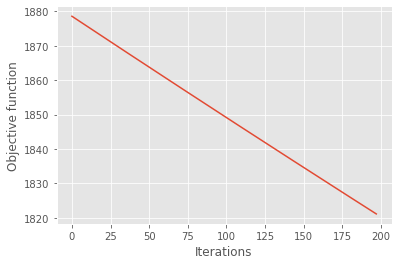

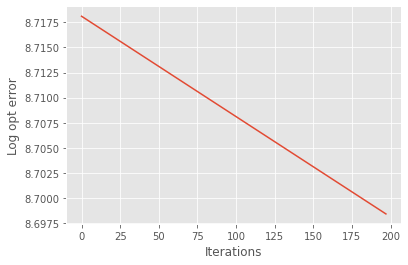

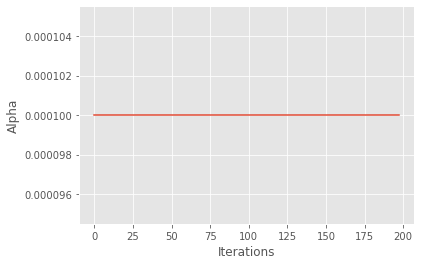

In [19]:
# Plot results showing the evolution of the algorithm

plt.plot(OF_iter[1:i]),plt.ylabel('Objective function'),plt.xlabel('Iterations')
plt.show()

plt.plot(np.log(tol_iter[1:i])),plt.ylabel('Log opt error'),plt.xlabel('Iterations')
plt.show()

plt.plot(alpha_iter[1:i]),plt.ylabel('Alpha'),plt.xlabel('Iterations')
plt.show()
